In [1]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

C:\Users\ricca\AppData\Local\Temp\ipykernel_12740\4233083143.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IR_KIDS_CHAR\2o raff\RES_DATA'

In [4]:
data = pd.read_csv(parent+r'\RES2.txt', sep='\t')

In [18]:
def resonance_model(f, pars):
    x = (f-pars[3])/pars[3]
    return 1-(pars[0]/pars[1])*(np.exp(1j*pars[2])/(1+1j*2*x*pars[0]))

polyorder = 2

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return pol*np.abs(res)

def phase(x,*pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.unwrap(np.angle(1j*res.imag+res.real+pol))

In [27]:
F = data['F']
I = data['I']
Q = data['Q']

In [28]:
F = np.array(F)
C = np.array(Q)+1j*np.array(I)
A = np.abs(C)
P = np.unwrap(np.angle(C))

Text(0, 0.5, '$\\phi$ [rad]')

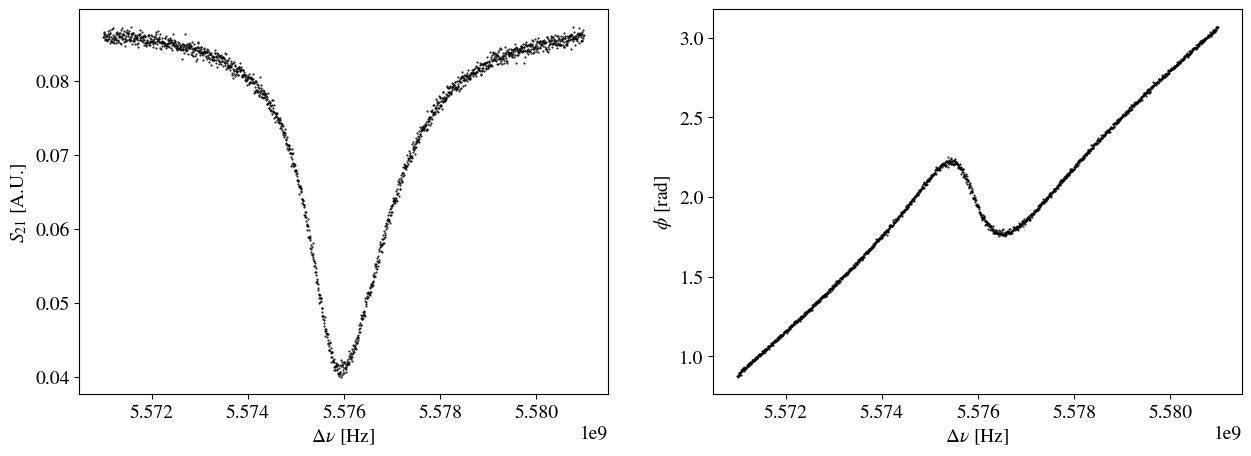

In [29]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')

In [30]:
A = 20*np.log10(np.sqrt(A))
#F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F,P,1)
P = P - np.polyval(a,F)
len_fit = int(np.floor(len(A)/10))
pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))   

In [31]:
pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

In [44]:
p0 = [1e-21,1e-15,-10,2e3,6e3,3.2,5.576*1e9]

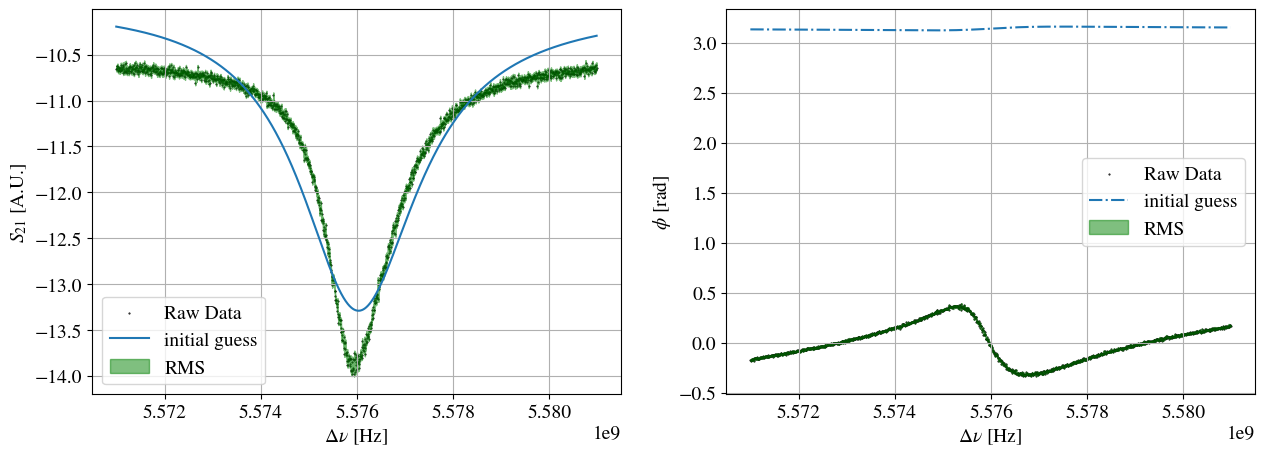

In [45]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F,model(F,*p0), label='initial guess')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].plot(F,phase(F,*p0),linestyle='-.', label='initial guess')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [46]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4197 (χ²/ndof = 2.6)       │              Nfcn = 358              │
│ EDM = 1.01e-06 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 2.01e-18  │ 0.04e-18  │            │            │         │         │       │
│ 1 │ x1   │-36.82e-12 │ 0.11e-12  │            │            │         │         │       │
│ 2 │ x2   │   -72.9   │    1.2    │            │            │         │         │       │
│ 3 │ x3   │  3.735e3  │  0.006e3  │            │            │         │         │       │
│ 4 │ x4   │ 11.891e3  │  0.018e3  │            │            │         │         │       │
│ 5 │ x5   │  3.3278   │  0.0020   │            │            │         │         │       │
│ 6 │ x6   │5.5759203e9│0.0000013e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                             x0                             x1                             x2                             x3                             x4                             x5                             x6 │
├────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                       1.43e-39                  -320.3367e-36    -44.3304615514368407503e-21    -11.8011141974224216256e-21    -65.4121438484125263813e-21        61.5491409943761028e-24 -31.0519356803620247831077e-18 │
│ x1 │                  -320.3367e-36                       1.24e-26             9.970803817929e-15          -258.473199832119e-15          -991.946358411486e-15              -27.238225789e-18         17.688918909397490e-12 │
│ x2 │    -44.3304615514368407503e-21             9.970803817929e-15                           1.38                            0.4                            2.0                      -1.914e-3                          965.6 │
│ x3 │    -11.8011141974224216256e-21          -258.473199832119e-15                            0.4                           33.9                             86                         107e-6                           -389 │
│ x4 │    -65.4121438484125263813e-21          -991.946358411486e-15                            2.0                             86                            308                        -679e-6                        -0.64e3 │
│ x5 │        61.5491409943761028e-24              -27.238225789e-18                      -1.914e-3                         107e-6                        -679e-6                       3.89e-06                      -2.188938 │
│ x6 │ -31.0519356803620247831077e-18         17.6889

In [47]:
lsqp = LeastSquares(F,P,P_rms*np.ones(len(P)),phase)
mp = minuit.Minuit(lsqp, *p0)
mp.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.227e+05 (χ²/ndof = 327.9)│             Nfcn = 10001             │
│ EDM = 0.0038 (Goal: 0.0002)      │            time = 5.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 2.11e-18  │ 0.20e-18  │            │            │         │         │       │
│ 1 │ x1   │  30.9e-9  │  3.5e-9   │            │            │         │         │       │
│ 2 │ x2   │    280    │    33     │            │            │         │         │       │
│ 3 │ x3   │  9.425e3  │  0.018e3  │            │            │         │         │       │
│ 4 │ x4   │   21.7    │    2.5    │            │            │         │         │       │
│ 5 │ x5   │  3.2314   │  0.0017   │            │            │         │         │       │
│ 6 │ x6   │5.5759216e9│0.0000009e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                          x0                          x1                          x2                          x3                          x4                          x5                          x6 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                     3.8e-38            687.43475483e-30  6.50035474972158056062e-18  -175.92769621998726848e-21  -488.11801437364613321e-21       -5.08281821753880e-24 18.71602035262800001192e-18 │
│ x1 │            687.43475483e-30                    1.24e-17            117.703808756e-9             -3.195923763e-9             -8.838500426e-9                 -92.130e-15            338.941909050e-9 │
│ x2 │  6.50035474972158056062e-18            117.703808756e-9                    1.11e+03                     -0.03e3                         -84                   -871.3e-6                       3.2e3 │
│ x3 │  -175.92769621998726848e-21             -3.195923763e-9                     -0.03e3                         328                           3                    617.9e-6                      0.46e3 │
│ x4 │  -488.11801437364613321e-21             -8.838500426e-9                         -84                           3                        6.28                     66.5e-6                        -237 │
│ x5 │       -5.08281821753880e-24                 -92.130e-15                   -871.3e-6                    617.9e-6                     66.5e-6                    2.76e-06                  -1.1302773 │
│ x6 │ 18.71602035262800001192e-18            338.941909050e-9                       3.2e3                      0.46e3                        -237                  -1.1302773                    7.44e+05 │
└────┴───────────────────────────────

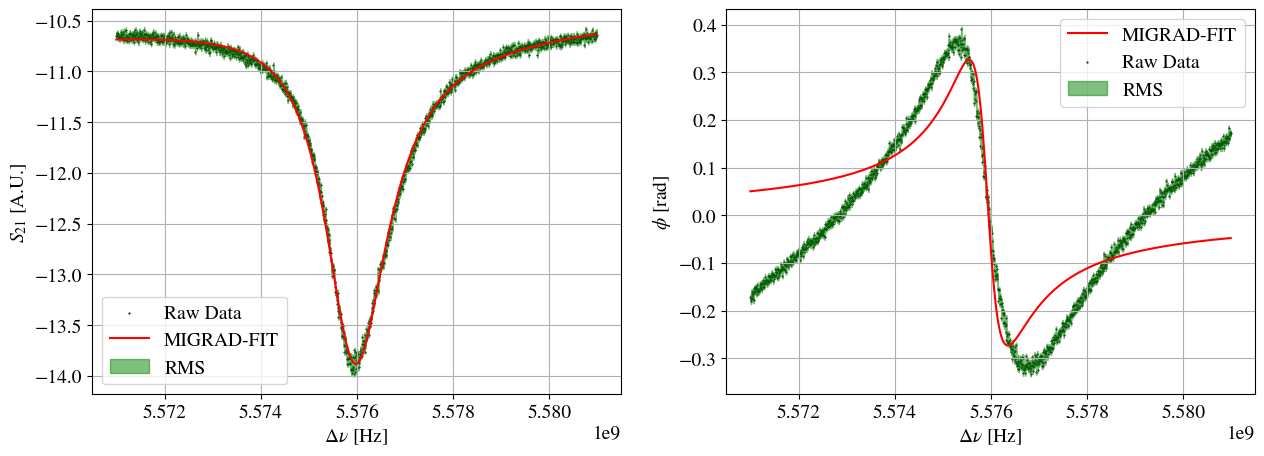

In [49]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs[1].plot(F, phase(F,*mp.values), color='red',label='MIGRAD-FIT')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [50]:
print('Q(S21) = ', m.values[3])
print('Q(phase) = ', mp.values[3])
print('Q_c(S21) = ', m.values[4])
print('Q_c(phase) = ', mp.values[4])

Q(S21) =  3734.721893839281
Q(phase) =  9424.922849125292
Q_c(S21) =  11890.816821538274
Q_c(phase) =  21.713688169078452


In [51]:
Qi = (m.values[3]**(-1)+m.values[4]**(-1))**(-1)
print('Qi(S21) = ',Qi)

Qi(S21) =  2842.0712224998233
